# 0. Instructions

**Follow the universal workflow of DLWP 4.5 (1st edition) for a problem and dataset of your choice**.

You can use the tensorflow datasets, MNIST, Reuters, IMDB and Boston Housing Price, or an external dataset. Work exclusively in this Jupyter notebook.

**You can only use DLWP Part 1 layers (Chapters 1-4) i.e. restrict your models to tensorflow sequential Dense and Dropout layers**.

A text cell and sometimes a code cell follows each section heading. These cells are for your response to the section title. The text that you add in these cells form the major component of the awarded grade. The aim is to use the section headings to construct a formal project report. What you did, and why, and what was the outcome: explanations, interpretations, evaluations and conclusions. You can add cells; above all, you must prepare a well-structured and readable document.

You can use as much DLWP code and code from the video notebooks as you wish but you must reference all code that is not original.

Export this Jupyter notebook to html and submit. Do not submit this notebook or any data files. Submit only the html export of this notebook.

(For Colab users: Colab does not have an html facility. Either:
Download the colab notebook and load into Jupyter; you will then be able to export as html
or

Follow the instructions in this blog https://python.plainenglish.io/how-to-convert-google-colab-notebook-ipynb-to-html-ccfeda199246 i.e. download from colab and then reload into colab's session storage. Then run the script
%%shelljupyter nbconvert --to html /Your notebook path/file.ipynb
and download the html version.)


# 1. Problem definition and dataset

Weather forecasting is an important application that affects our daily lives, with significant implications across various sectors such as agriculture and air travel. Accurate weather predictions can have a significant impact in mitigation of adverse effects of natural events and improve safety and prepardness in a lot of scenarios.

Given a historical weather dataset with various meteorological features recorded over time, the goal of this study is to build a machine learning model that can predict future weather conditions. Specifically, the focus will be on forecasting temperature.

This problem falls under the category of time series forecasting, a type of regression analysis where the input data is ordered in time but as a note I want to add to this exercise, given the restriction of only being able to use Dense and Dropout layers, we are going to be dropping the time series aspect and treat each weather observation as independent of others as Dense layers lack temporal awareness.

For this I will be using the Jena climate dataset by the Max Planck Institute for Biogeochemistry[1], this dataset has 14 features recorded every 10 minutes, starting from Jan 10th 2009 to Dec 31st 2016.

Let's download the dataset and explore its features and data.

In [28]:
from keras import utils
import pandas as pd

# Download dataset zip file from google object storage
weather_dataset_zip_file_path = utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

# Read the file into a panda dataframe
df = pd.read_csv(weather_dataset_zip_file_path[:-4])
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


This table shows the different description for each data point in the set.

| Name            | Description                                                                             |
| --------------- | --------------------------------------------------------------------------------------- |
| Date Time       | Date-time reference                                                                     |
| p (mbar)        | The pascal SI derived unit of pressure used to quantify internal pressure in millibars. |
| T (degC)        | Temperature in Celsius                                                                  |
| Tpot (K)        | Temperature in Kelvin                                                                   |
| Tdew (degC)     | Temperature in Celsius relative to humidity                                             |
| rh (%)	      | Relative Humidity is a measure of how saturated the air is with water vapor             |
| VPmax (mbar)    | Saturation vapor pressure                                                               |
| VPact (mbar)    | Vapor pressure                                                                          |
| VPdef (mbar)    | Vapor pressure deficit                                                                  |
| sh (g/kg)	      | Specific humidity                                                                       |
| H2OC (mmol/mol) | Water vapor concentration                                                               |
| rho (g/m**3)    | Airtight                                                                                |
| wv (m/s)	      | Wind speed                                                                              |
| max. wv (m/s)	  | Maximum wind speed                                                                      |
| wd (deg)	      | Wind direction in degrees                                                               |


Let's graph the raw data of the last year to show the different patterns for each feature in the dataset.

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>],
      dtype=object)

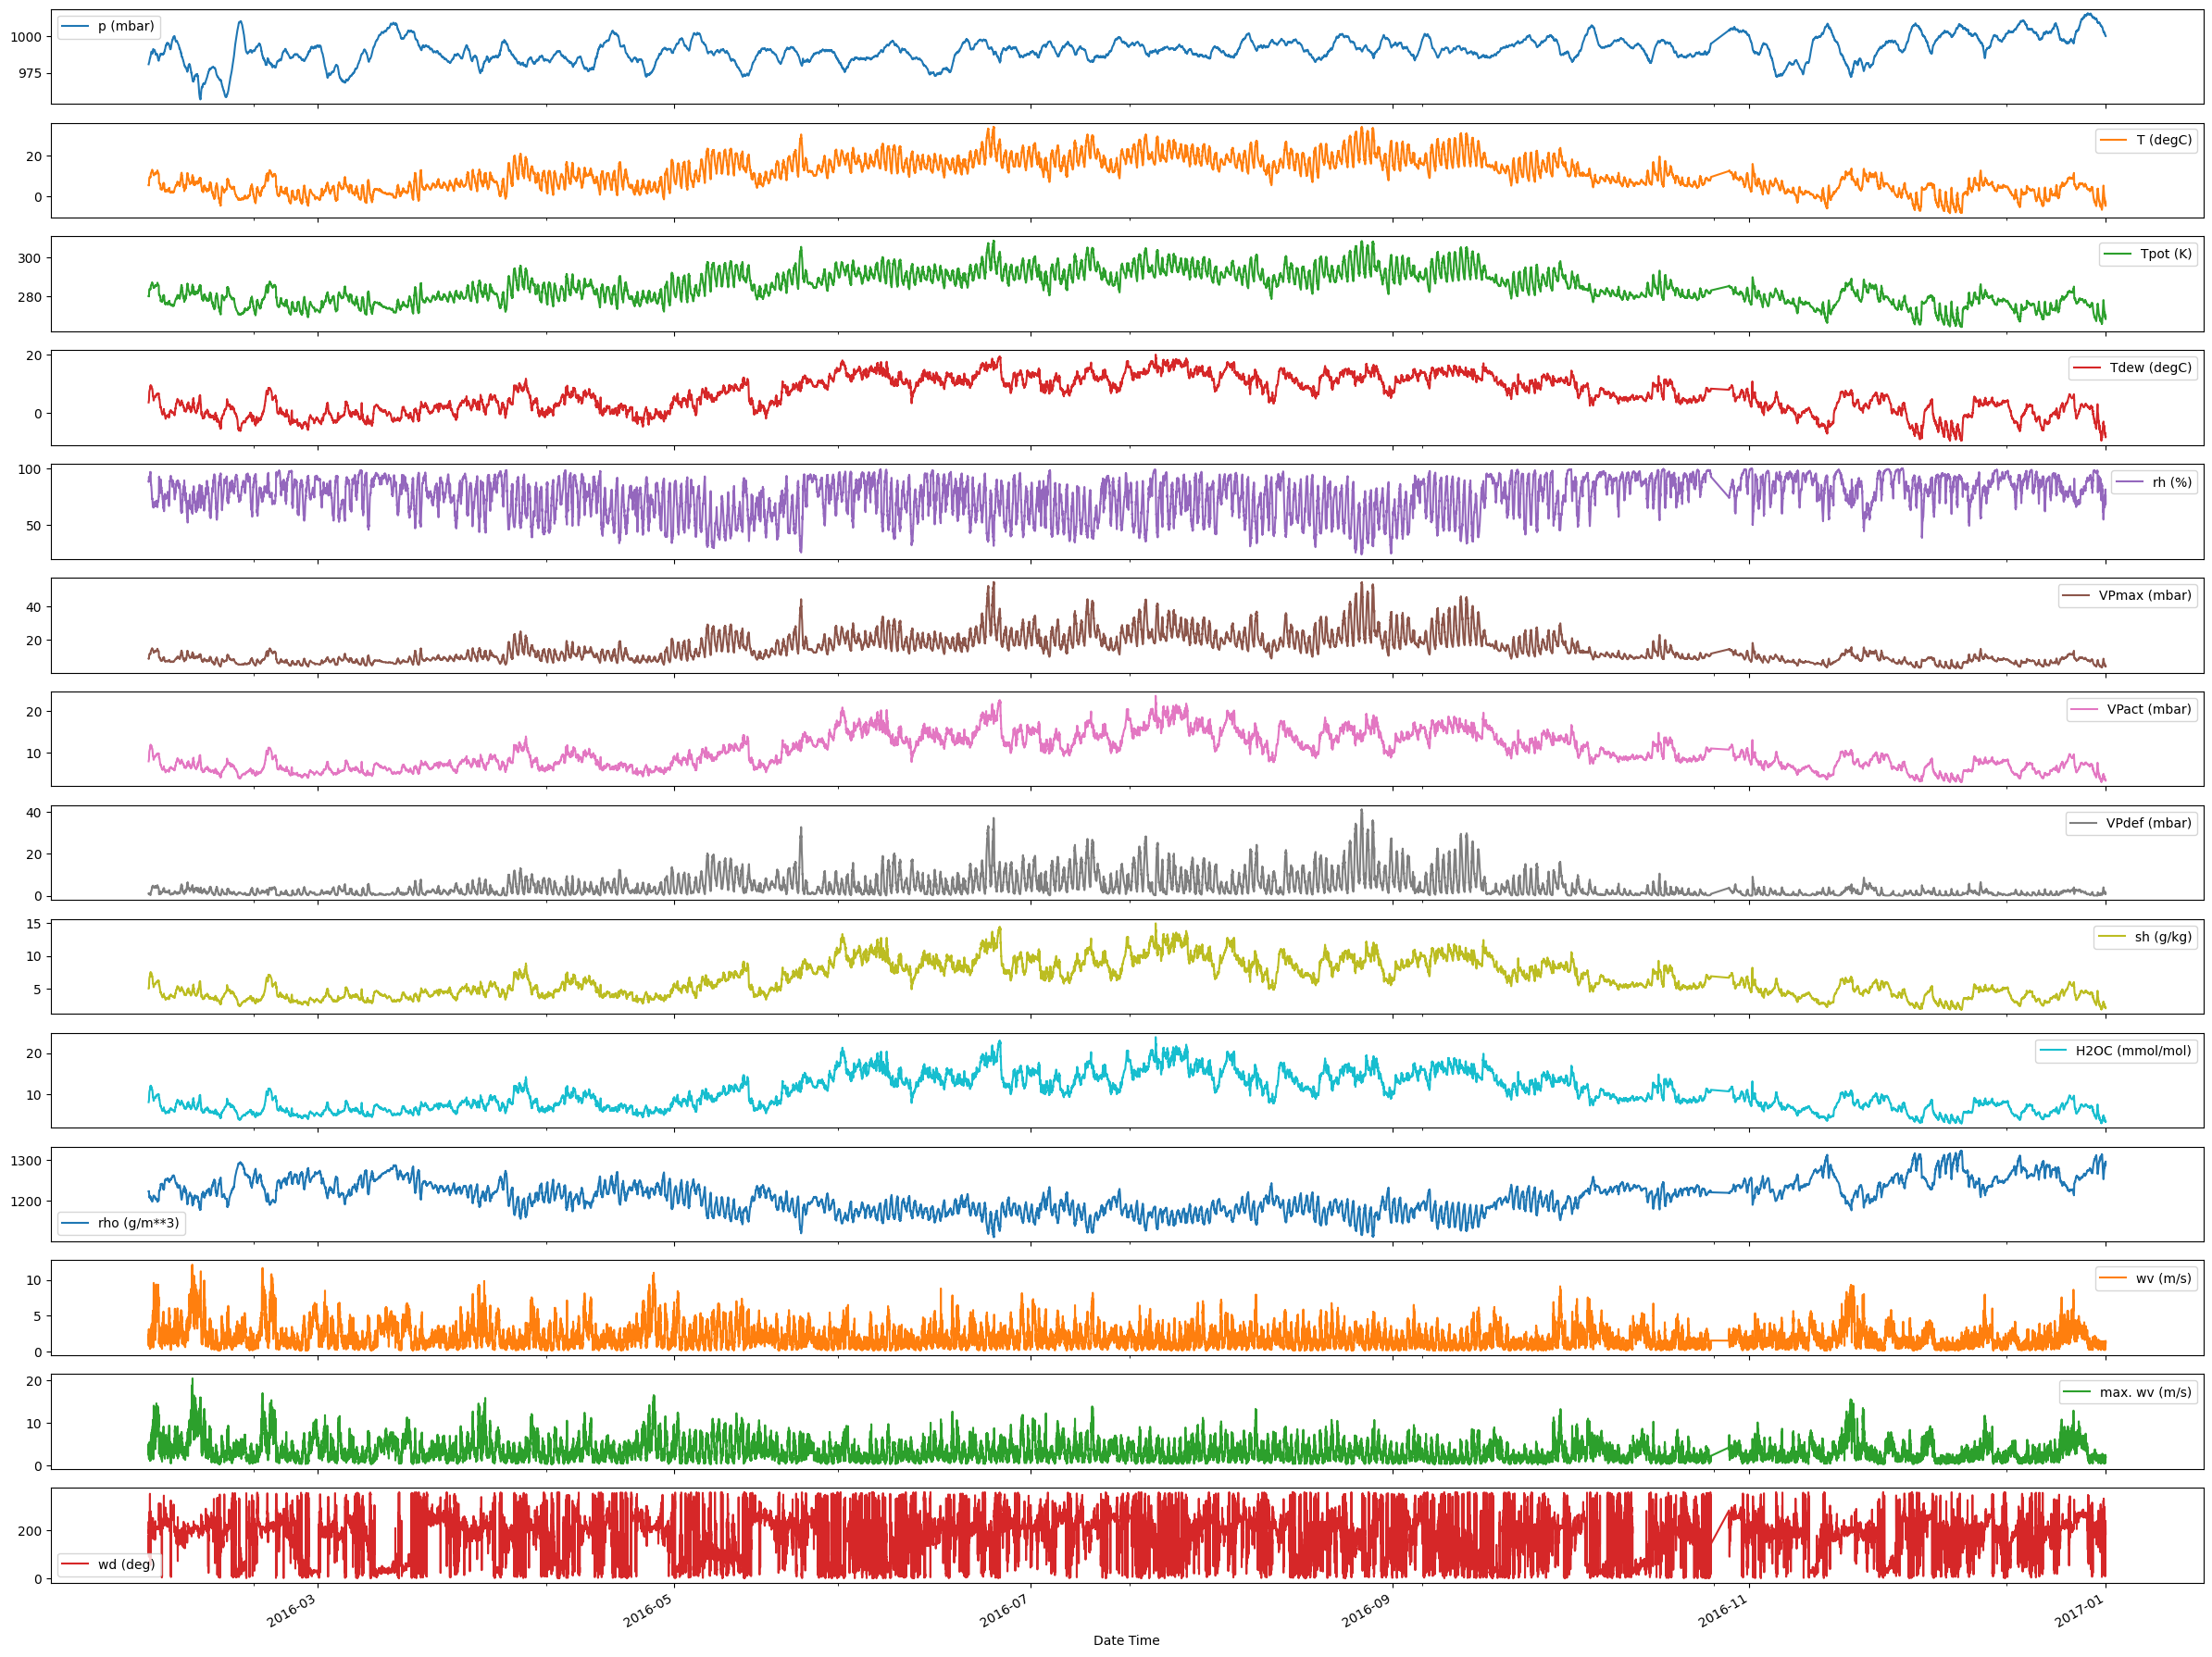

In [29]:
df_copy = df.copy()

plot_columns = df_copy.columns
plot_features = df_copy[plot_columns][len(df_copy)-47795:]

plt_date_time = pd.to_datetime(df_copy.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
plot_features.index = plt_date_time[len(df_copy)-47795:]

plot_features.plot(subplots=True, figsize=(30, 25))

# 2. Success metric(s)

As this will be a regression model, I'll be using the Mean Absolute Error as a success metric.

$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$​

where:
* $n$ is the number of data points
* $y_i$ represents the actual vaule of the target variable for the $i$-th observation
* $\hat{y}_i$ represents the predicted value for the $i$-th observation

MAE represents the average magnitude of the errors in the same unit as the target variables, making it easy to interpret. Is also less sensitive to outliers when compared to Mean Squared Error, which I think will be better for this problem as very rare weather events might not be significant for an accurate prediction.

# 3. Evaluation protocol

For my evaluation protocol I'll be maintaing a hold-out validation set. Meaning I'll be splitting the data set into three distinct subsets:
* Training Set: Used to train the model
* Validation Set: Used to fine-tune the model's hyperparameters and prevent overfitting
* Test Set: Used to assess the final performance of the model on new unseen data.

Reasoning for choosing this method:
* Prevents Data Leakage: This method ensures that the validation and test data are kept completely separate from the training data. This separation prevents data leakage, where information from the test set might inadvertently influence the model, leading to overly optimistic performance estimates.
* Effective for large datasets: When a large amount of data is available, the hold-out mehitd is effective as it allows sufcfient data for both training the model and evaluating it.
* Addresses Time Dependency in a Time Series Dataset: By partitioning the data chronologically, we ensure that the model is trained on past data and evaluated on future data, which reflects the real-world scenario where predictions are made for future time points based on historical observations.


# 4. Data preparation

For this section, I'll first be looking at the statistics of the dataset to inspect if there is anything that stands out that should be corrected before normalizing and splitting the dataset, such as missing values.

I will then be doing some feature engineering to understand if there are any values in the dataset that need transformation as they aren't good inputs for training our model, we want all values to be formatted as tensors[2] and ideally scaled to smaller values.

After this I will normalise each feature independently[3], this dataset has features that takes values in different ranges, so they would need to be scaled and normalised to have a mean of 0 and a standard deviation of 1.

This dataset provides a data point in 10 minute interval, I want to limit my model to hourly predictions, so I'm going to first sample the data to one-hour intervals instead and convert the datetime from a string to a pandas datetime type.

In [30]:
df = df[5::6]
df["Date Time"] = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [31]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
p (mbar),70091.0,989.212842,913.6,984.2,989.57,994.72,1015.29,8.358886
T (degC),70091.0,9.450482,-22.76,3.35,9.41,15.48,37.28,8.423384
Tpot (K),70091.0,283.493086,250.85,277.44,283.46,289.53,311.21,8.504424
Tdew (degC),70091.0,4.956471,-24.8,0.24,5.21,10.08,23.06,6.730081
rh (%),70091.0,76.009788,13.88,65.21,79.3,89.4,100.0,16.47492
VPmax (mbar),70091.0,13.576576,0.97,7.77,11.82,17.61,63.77,7.739883
VPact (mbar),70091.0,9.533968,0.81,6.22,8.86,12.36,28.25,4.183658
VPdef (mbar),70091.0,4.042536,0.0,0.87,2.19,5.3,46.01,4.898549
sh (g/kg),70091.0,6.02256,0.51,3.92,5.59,7.8,18.07,2.655812
H2OC (mmol/mol),70091.0,9.640437,0.81,6.29,8.96,12.49,28.74,4.234862


From the table above, the minimum values for `wv (m/s)` and `max. wv (m/s)` stand out as they represent wind speed so they should always be greater than zero. I'm going to be replacing these missing[3] values with 0.

In [32]:
df.loc[df['wv (m/s)'] < 0, 'wv (m/s)'] = 0.0
df.loc[df['max. wv (m/s)'] < 0, 'max. wv (m/s)'] = 0.0

print('wv (m/s) min:', df['wv (m/s)'].min())
print('max. wv (m/s) min:', df['max. wv (m/s)'].min())

wv (m/s) min: 0.0
max. wv (m/s) min: 0.0


The dataset has direction of wind in degrees, this will most likely be an issue for our ML model due to the circular nature of it, the non-linearity will make it challenging for the model to learn a meaningful pattern from the data as the transition from 359° degress to 0° or 360° is mathematically very small but numerically it looks like a large jump.

So instead of representing the direction of wind in degrees I'm going to transform it into polar coordinates. Let's first plot our current distribution of wind data[4], to have a graphical representation of the before and after. This will be Direction over Velocity:

Text(0, 0.5, 'Wind Velocity [m/s]')

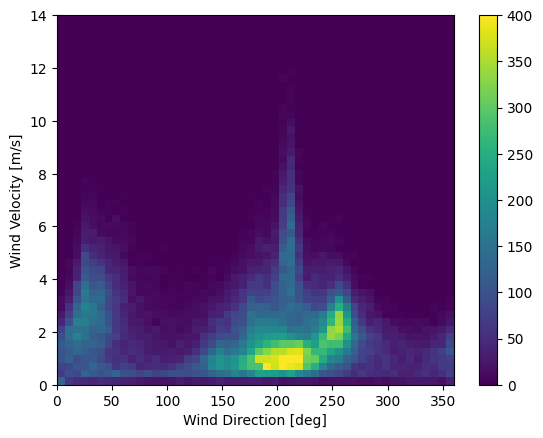

In [33]:
import matplotlib.pyplot as plt

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Now let's convert it to the polar coordinates per the following formula

$x = v * \cos(\theta)$

$y = v * \sin(\theta)$

Where $\theta$ is the wind direction in radians and $v$ is the wind velocity

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

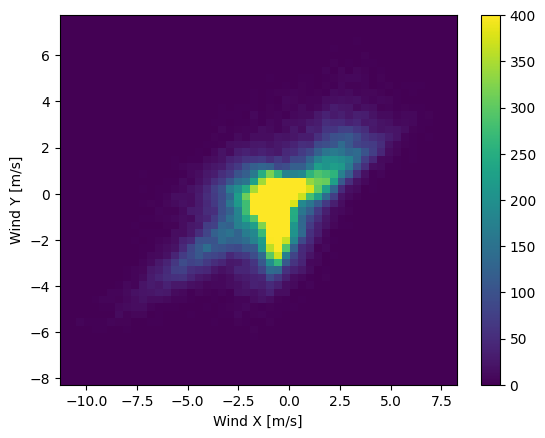

In [34]:
import numpy as np

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

One of the features of the dataset is the datetime of the weather events at that moment in time, I need to convert this into something the model can successfully use in training. Keeping in line with Francois Chollet recommendations of avoiding having large numbers I want to avoid expressing the datetime as a timestamp in seconds since the unix epoch, as those would be very large numbers, but also because weather patterns are inherently cycical in nature and are influenced by Seasonal Cycles and I want my ML model to understand that.

So, as the hours of the day, days of the week and months of the year are cyclical, I'm going to transform the datetime into a format that reflects their cyclical nature.

For this I'll be calculating both sine and cosine for each hour, month and day of the week on each datapoint in the set. The reason why I'm using both sine and cosine is to be able to distinguish between two points that have the sine (or cosine) value but different cosine (or sine) value.

In [35]:
# Extract components
df['month'] = df['Date Time'].dt.month
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['hour'] = df['Date Time'].dt.hour

df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

Let's show the hour cycles in a plot as it would be the one changing the most for all datapoints.

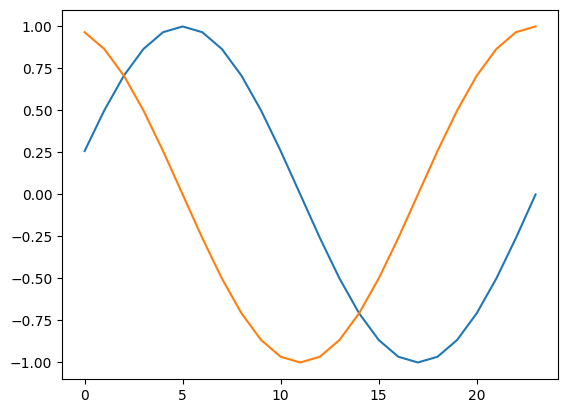

In [36]:
plt.plot(np.array(df['sin_hour'])[:24])
plt.plot(np.array(df['cos_hour'])[:24])

Let's split and normalise the data now, as I mentioned before I'll be using a hold-out validation set for evaluation. So I'm going to split the data into:
* 70% for training
* 20% for validation
* 10% for tests

In [37]:
columns_to_use = [
    'p (mbar)',
    'T (degC)',
    'Tpot (K)',
    'Tdew (degC)',
    'rh (%)',
    'VPmax (mbar)',
    'VPact (mbar)',
    'VPdef (mbar)',
    'sh (g/kg)',
    'H2OC (mmol/mol)',
    'rho (g/m**3)',
    'Wx',
    'Wy',
    'max Wx',
    'max Wy',
    'sin_hour',
    'cos_hour',
    'sin_month',
    'cos_month',
    'sin_day_of_week',
    'cos_day_of_week'
]

df_copy = df[columns_to_use]

n = len(df_copy)
train_df = df_copy[0:int(n*0.7)]
val_df = df_copy[int(n*0.7)+1:int(n*0.9)]
test_df = df_copy[int(n*0.9)+1:]

num_features = df_copy.shape[1]


# Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_26578/494701039.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df_copy.keys(), rotation=90)


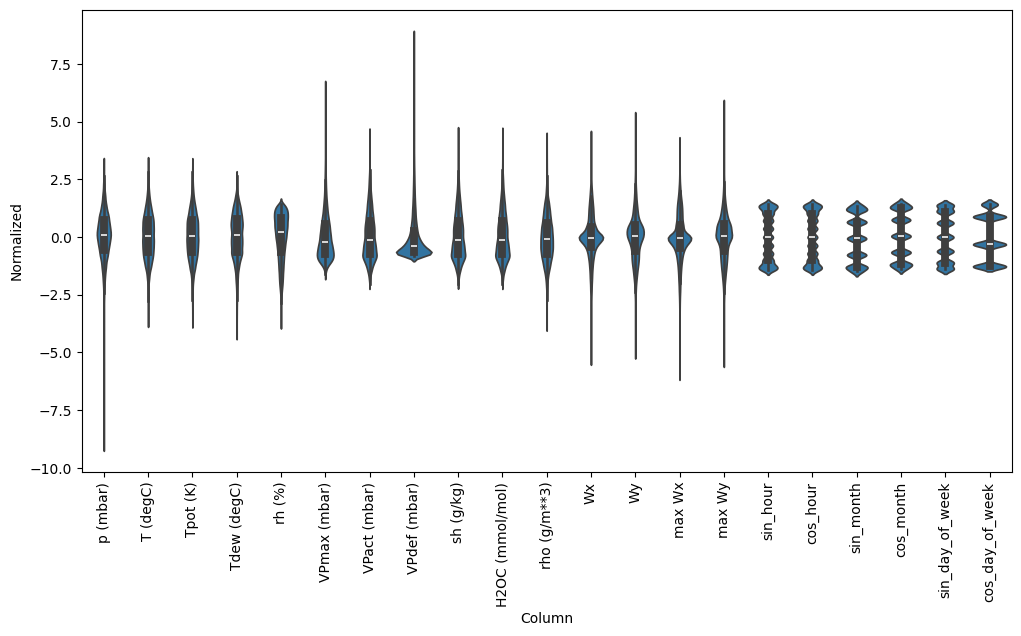

In [38]:
import seaborn as sns

df_std = (df_copy - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_copy.keys(), rotation=90)

# 5. Gaining statistical power

With the dataset ready, I'm going to build a very basic baseline model that I will use to compare future models as to achieve statistical power[5].

For this baseline model I will use a single input layer with 2 neurons for both my outputs.

I'm going to use the `rmsprop` optimizer and the `mae` loss function as a starting point. The model will be initially trained for 20 epochs.

In [39]:
from keras import models, layers

features_to_use = [
    'p (mbar)',
    'VPmax (mbar)',
    'VPact (mbar)',
    'VPdef (mbar)',
    'sh (g/kg)',
    'H2OC (mmol/mol)',
    'rho (g/m**3)',
    'Wx',
    'Wy',
    'max Wx',
    'max Wy',
    'sin_hour',
    'cos_hour',
    'sin_month',
    'cos_month',
    'sin_day_of_week',
    'cos_day_of_week'
]

labels_to_use = [
    'T (degC)',
    'rh (%)'
]

train_x = train_df[features_to_use]
train_y = train_df[labels_to_use]

val_x = val_df[features_to_use]
val_y = val_df[labels_to_use]

input_shape = train_x.shape[1]

model = models.Sequential()
model.add(layers.Dense(2, input_shape=(input_shape,)))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

baseline_history = model.fit(train_x, train_y, epochs=20, validation_data=(val_x, val_y))

Epoch 1/20


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - loss: 0.6030 - mae: 0.5315 - val_loss: 0.0674 - val_mae: 0.1655
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - loss: 0.0698 - mae: 0.1598 - val_loss: 0.0612 - val_mae: 0.1377
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - loss: 0.0665 - mae: 0.1438 - val_loss: 0.0586 - val_mae: 0.1348
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - loss: 0.0673 - mae: 0.1441 - val_loss: 0.0582 - val_mae: 0.1314
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.0668 - mae: 0.1436 - val_loss: 0.0580 - val_mae: 0.1344
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 0.0672 - mae: 0.1437 - val_loss: 0.0597 - val_mae: 0.1360
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 0.0666 - mae: 0.1439 - val_loss: 0.0571 - val_mae: 0.1360
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - loss: 0.0662 - mae: 0.1432 - val_loss: 0.0574 - val_mae: 0.1344
Epoch 9/20
1534/1534 ━━━━━━━━━━━━━━

Let's look at the loss for our model from the validation set.

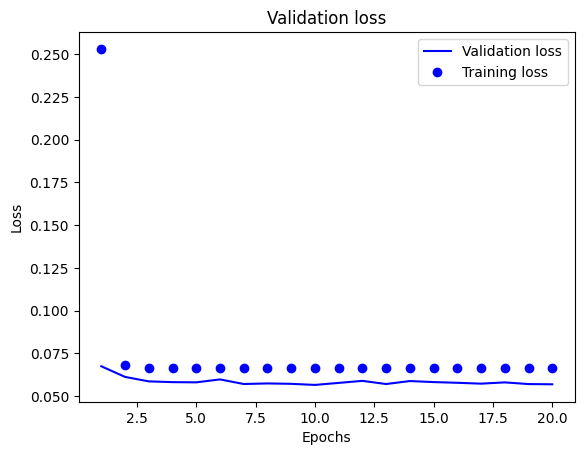

In [40]:
baseline_loss = baseline_history.history['loss']
baseline_val_loss = baseline_history.history['val_loss']
epochs = range(1, len(baseline_loss) + 1)

plt.plot(epochs, baseline_val_loss, 'b', label="Validation loss")
plt.plot(epochs, baseline_loss, 'bo', label="Training loss")
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

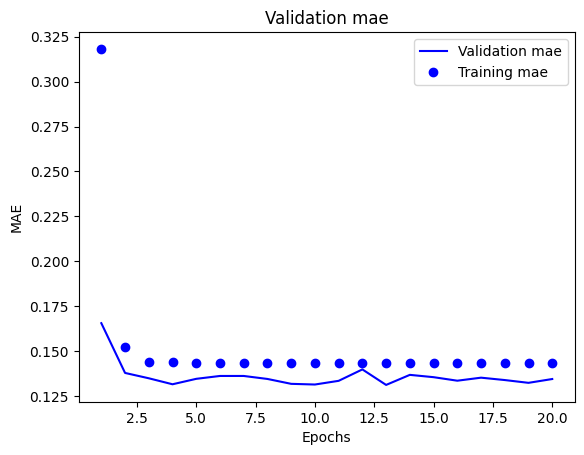

In [41]:
baseline_mae = baseline_history.history['mae']
baseline_val_mae = baseline_history.history['val_mae']
epochs = range(1, len(baseline_mae) + 1)

plt.plot(epochs, baseline_val_mae, 'b', label="Validation mae")
plt.plot(epochs, baseline_mae, 'bo', label="Training mae")
plt.title("Validation mae")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [42]:
test_x = test_df[features_to_use]
test_y = test_df[labels_to_use]

overall_loss, mae = model.evaluate(test_x, test_y, verbose=1)

print(f"Loss for test data: {overall_loss:.6f}")
print(f"MAE for test data: {mae:.6f}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0497 - mae: 0.1265
Loss for test data: 0.054589
MAE for test data: 0.129944


So this is a very basic dump baseline model that clearly doesn't fit my model, there is no improvement between epochs which is an indication of underfitting, now I want to achieve some statistical power by improving this model.

I'm going to increase the capacity and add a hidden layer, the behaviour I'm looking for is to have a model that sees improvement on each epoch.

In [43]:
model = models.Sequential()
model.add(layers.Dense(16, input_shape=(input_shape,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

statistical_power_history = model.fit(train_x, train_y, epochs=20, validation_data=(val_x, val_y))

Epoch 1/20


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step - loss: 0.1698 - mae: 0.2417 - val_loss: 0.0094 - val_mae: 0.0639
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.0100 - mae: 0.0653 - val_loss: 0.0072 - val_mae: 0.0596
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - loss: 0.0067 - mae: 0.0541 - val_loss: 0.0048 - val_mae: 0.0475
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - loss: 0.0054 - mae: 0.0485 - val_loss: 0.0068 - val_mae: 0.0560
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - loss: 0.0048 - mae: 0.0456 - val_loss: 0.0043 - val_mae: 0.0439
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step - loss: 0.0047 - mae: 0.0437 - val_loss: 0.0036 - val_mae: 0.0402
Epoch 7/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - loss: 0.0046 - mae: 0.0422 - val_loss: 0.0044 - val_mae: 0.0444
Epoch 8/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - loss: 0.0044 - mae: 0.0408 - val_loss: 0.0055 - val_mae: 0.0491
Epoch 9/20
1534/1534 ━━━━━━━━━━━━━━

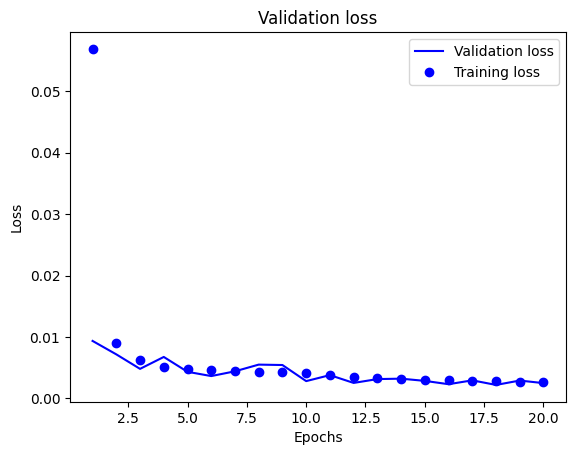

In [44]:
new_model_loss = statistical_power_history.history['loss']
new_model_val_loss = statistical_power_history.history['val_loss']
epochs = range(1, len(new_model_loss) + 1)

plt.plot(epochs, new_model_val_loss, 'b', label="Validation loss")
plt.plot(epochs, new_model_loss, 'bo', label="Training loss")
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

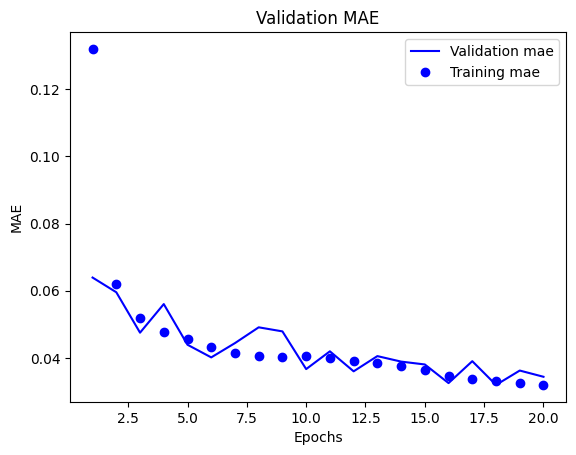

In [45]:
new_model_mae = statistical_power_history.history['mae']
new_model_val_mae = statistical_power_history.history['val_mae']
epochs = range(1, len(new_model_mae) + 1)

plt.plot(epochs, new_model_val_mae, 'b', label="Validation mae")
plt.plot(epochs, new_model_mae, 'bo', label="Training mae")
plt.title("Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

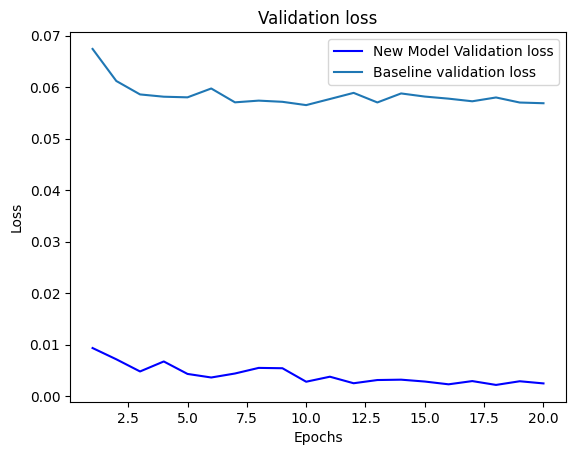

In [46]:
plt.plot(epochs, new_model_val_loss, 'b', label="New Model Validation loss")
plt.plot(epochs, baseline_val_loss, label="Baseline validation loss")
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
test_x = test_df[features_to_use]
test_y = test_df[labels_to_use]

overall_loss, mae = model.evaluate(test_x, test_y, verbose=1)

print(f"Loss for test data: {overall_loss:.6f}")
print(f"MAE for test data: {mae:.6f}")

  1/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0011 - mae: 0.0252

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.0023 - mae: 0.0319
Loss for test data: 0.002841
MAE for test data: 0.034127


As this model outputs 2 variables the validation loss (MAE) shown here is a combined metric for both variables. Looking at plot the training loss is steadily decreasing over the course of the epochs, validation loss seems to almost follow the training loss metric and stabilizing around epcoh 10. This could indicate that the model is generalizing well to unseen data in the validation set.

When compared to the baseline model, the validation loss is significantly lower, but as I'm writting this I would say it wasn't the output I'm expecting, as this could mean the dataset might just have relatively simple patterns that are easy for the model to learn and generalize, the output variables could be based on a simple linear relationship with the other input variables where a linear regression model might achieve near-perfect performance.

For the purpose of the exercise statistical power has been achieved, but the next section could be challenging when trying to scale the model up to overfit if my previous assumption is correct.

# 6. Scaling up

Now that we have achieved statistical power, let's try to figure out if the model is sufficiently powerful and figure out if my previous assumption is correct. For this let's try to develop a model that overfits, I'm going to be adding extra layers, neurons and training for significantly more epochs.

What I want to see when I plot the MAE loss metric is that the validation loss at some point start trending up, this would indicate the model is overfitting and at that point is where I want to tune it.

In [48]:
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_one_history = model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))


Epoch 1/100


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - loss: 0.0796 - mae: 0.1534 - val_loss: 0.0102 - val_mae: 0.0720
Epoch 2/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.0061 - mae: 0.0520 - val_loss: 0.0046 - val_mae: 0.0474
Epoch 3/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - loss: 0.0043 - mae: 0.0436 - val_loss: 0.0030 - val_mae: 0.0444
Epoch 4/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - loss: 0.0036 - mae: 0.0399 - val_loss: 0.0013 - val_mae: 0.0249
Epoch 5/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - loss: 0.0030 - mae: 0.0362 - val_loss: 0.0056 - val_mae: 0.0577
Epoch 6/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0027 - mae: 0.0339 - val_loss: 0.0018 - val_mae: 0.0324
Epoch 7/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 0.0025 - mae: 0.0329 - val_loss: 0.0069 - val_mae: 0.0588
Epoch 8/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0023 - mae: 0.0316 - val_loss: 8.2155e-04 - val_mae: 0.0193
Epoch 9/100
1534/1534 ━━

In [49]:
model = models.Sequential()
model.add(layers.Dense(256, input_shape=(input_shape,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_two_history = model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))

Epoch 1/100


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0980 - mae: 0.1637 - val_loss: 0.0126 - val_mae: 0.0798
Epoch 2/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.0075 - mae: 0.0585 - val_loss: 0.0133 - val_mae: 0.0853
Epoch 3/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: 0.0053 - mae: 0.0494 - val_loss: 0.0029 - val_mae: 0.0416
Epoch 4/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.0040 - mae: 0.0429 - val_loss: 0.0153 - val_mae: 0.0908
Epoch 5/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 0.0035 - mae: 0.0403 - val_loss: 7.9960e-04 - val_mae: 0.0209
Epoch 6/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 0.0032 - mae: 0.0381 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 7/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 8/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - loss: 0.0026 - mae: 0.0342 - val_loss: 0.0020 - val_mae: 0.0325
Epoch 9/100
1534/1534 ━━━━

In [50]:
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(input_shape,)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_three_history = model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))

Epoch 1/100


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0765 - mae: 0.1594 - val_loss: 0.0091 - val_mae: 0.0750
Epoch 2/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0093 - mae: 0.0654 - val_loss: 0.0045 - val_mae: 0.0476
Epoch 3/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0063 - mae: 0.0537 - val_loss: 0.0162 - val_mae: 0.1035
Epoch 4/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0051 - mae: 0.0484 - val_loss: 0.0203 - val_mae: 0.1045
Epoch 5/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0043 - mae: 0.0443 - val_loss: 0.0049 - val_mae: 0.0476
Epoch 6/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0037 - mae: 0.0409 - val_loss: 0.0067 - val_mae: 0.0582
Epoch 7/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0028 - val_mae: 0.0394
Epoch 8/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0030 - mae: 0.0371 - val_loss: 0.0063 - val_mae: 0.0627
Epoch 9/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 2

In [51]:
model = models.Sequential()
model.add(layers.Dense(1024, input_shape=(input_shape,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_four_history = model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))


Epoch 1/100


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0794 - mae: 0.1741 - val_loss: 0.0123 - val_mae: 0.0766
Epoch 2/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0122 - mae: 0.0748 - val_loss: 0.0104 - val_mae: 0.0771
Epoch 3/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0081 - mae: 0.0609 - val_loss: 0.0079 - val_mae: 0.0659
Epoch 4/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0061 - mae: 0.0530 - val_loss: 0.0027 - val_mae: 0.0400
Epoch 5/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0051 - mae: 0.0479 - val_loss: 0.0163 - val_mae: 0.0834
Epoch 6/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0042 - mae: 0.0443 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 7/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0039 - mae: 0.0413 - val_loss: 0.0040 - val_mae: 0.0511
Epoch 8/100
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0033 - mae: 0.0397 - val_loss: 9.7858e-04 - val_mae: 0.0242
Epoch 9/100
1534/1534 ━━━━━━━━━━━━━━━━━━

In [52]:
model = models.Sequential()
model.add(layers.Dense(1024, input_shape=(input_shape,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_five_history = model.fit(train_x, train_y, epochs=250, validation_data=(val_x, val_y))

Epoch 1/250


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1162 - mae: 0.2215 - val_loss: 0.0108 - val_mae: 0.0830
Epoch 2/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0136 - mae: 0.0795 - val_loss: 0.0158 - val_mae: 0.0890
Epoch 3/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0087 - mae: 0.0629 - val_loss: 0.0094 - val_mae: 0.0658
Epoch 4/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0064 - mae: 0.0544 - val_loss: 0.0083 - val_mae: 0.0565
Epoch 5/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0053 - mae: 0.0485 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 6/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0043 - mae: 0.0448 - val_loss: 0.0053 - val_mae: 0.0549
Epoch 7/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0039 - mae: 0.0425 - val_loss: 9.3275e-04 - val_mae: 0.0233
Epoch 8/250
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0034 - mae: 0.0398 - val_loss: 0.0070 - val_mae: 0.0684
Epoch 9/250
1534/1534 ━━━━━━━━━━━━━━━━━━

In [63]:
model = models.Sequential()
model.add(layers.Dense(1024, input_shape=(input_shape,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_six_history = model.fit(train_x, train_y, epochs=500, validation_data=(val_x, val_y))

Epoch 1/500


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0787 - mae: 0.1695 - val_loss: 0.0217 - val_mae: 0.1152
Epoch 2/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0120 - mae: 0.0749 - val_loss: 0.0073 - val_mae: 0.0699
Epoch 3/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0081 - mae: 0.0600 - val_loss: 0.0071 - val_mae: 0.0616
Epoch 4/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0061 - mae: 0.0530 - val_loss: 0.0272 - val_mae: 0.0921
Epoch 5/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0053 - mae: 0.0483 - val_loss: 0.0030 - val_mae: 0.0427
Epoch 6/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0041 - mae: 0.0438 - val_loss: 0.0018 - val_mae: 0.0317
Epoch 7/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0036 - mae: 0.0410 - val_loss: 0.0022 - val_mae: 0.0355
Epoch 8/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0033 - mae: 0.0393 - val_loss: 0.0029 - val_mae: 0.0402
Epoch 9/500
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6

In [64]:
model = models.Sequential()
model.add(layers.Dense(1024, input_shape=(input_shape,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

iteration_seven_history = model.fit(train_x, train_y, epochs=1000, validation_data=(val_x, val_y))

Epoch 1/1000


/home/esgarcia/uol_workspace/machine-learning/final/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0979 - mae: 0.1855 - val_loss: 0.0569 - val_mae: 0.1443
Epoch 2/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0134 - mae: 0.0774 - val_loss: 0.0272 - val_mae: 0.1197
Epoch 3/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0086 - mae: 0.0626 - val_loss: 0.0035 - val_mae: 0.0444
Epoch 4/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0066 - mae: 0.0549 - val_loss: 0.0246 - val_mae: 0.1046
Epoch 5/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0054 - mae: 0.0496 - val_loss: 0.0055 - val_mae: 0.0579
Epoch 6/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0046 - mae: 0.0462 - val_loss: 0.0113 - val_mae: 0.0705
Epoch 7/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0040 - mae: 0.0429 - val_loss: 0.0049 - val_mae: 0.0475
Epoch 8/1000
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0035 - mae: 0.0401 - val_loss: 0.0153 - val_mae: 0.0788
Epoch 9/1000
1534/1534 ━━━━━━━━━━━━━━

/tmp/ipykernel_26578/1811746662.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_mae, 'b', color='red', label="Validation mae")


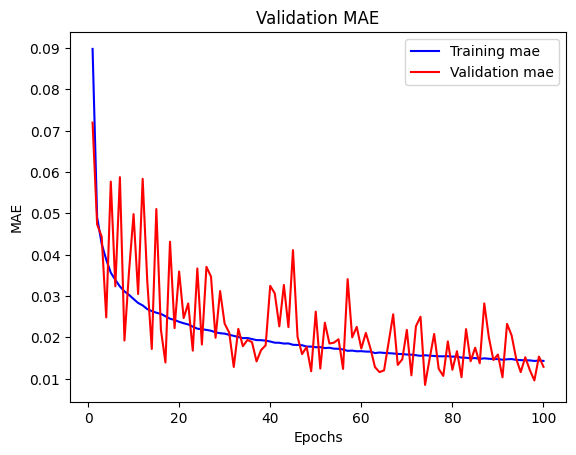

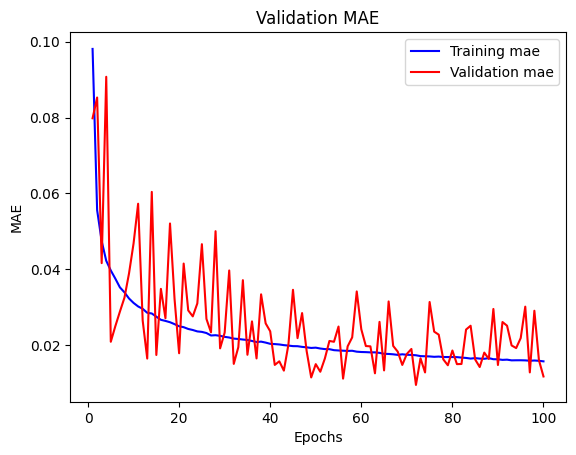

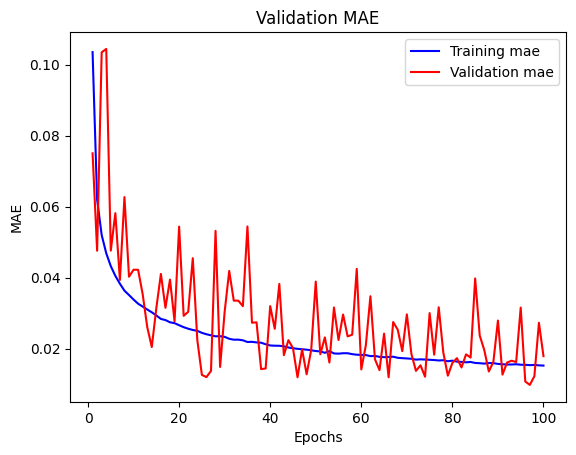

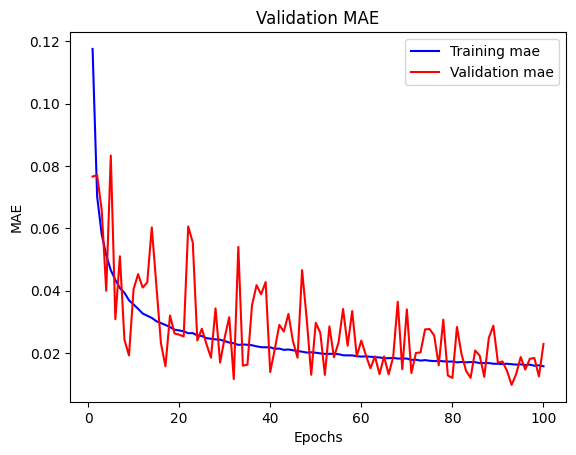

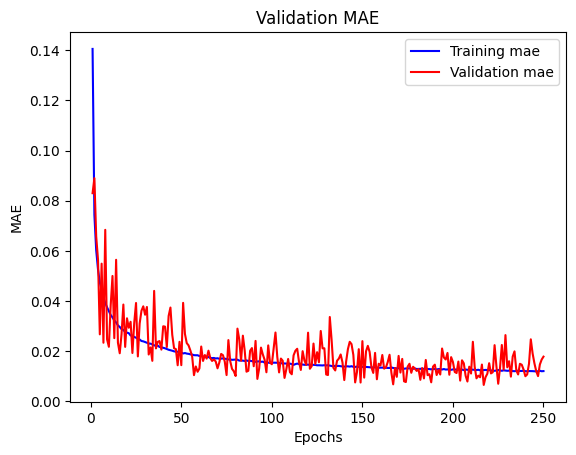

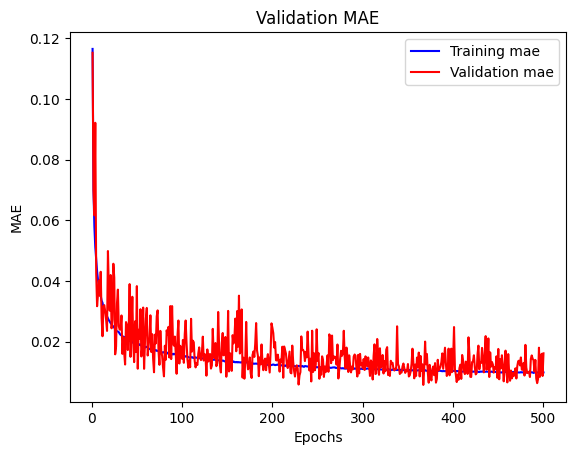

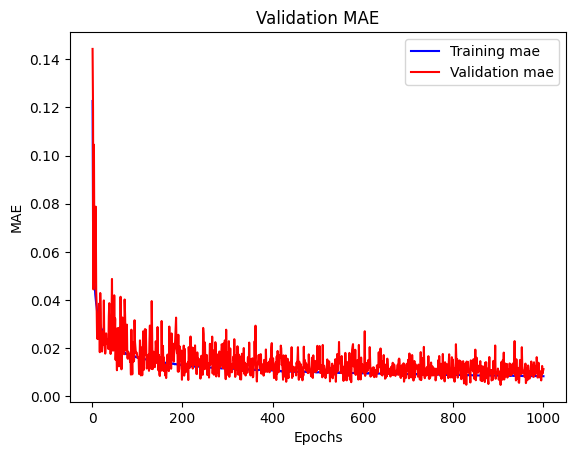

In [65]:
histories = [
    iteration_one_history,
    iteration_two_history,
    iteration_three_history,
    iteration_four_history,
    iteration_five_history,
    iteration_six_history,
    iteration_seven_history
]

max_epoch = 0

for h in histories:
    mae = h.history['mae']
    val_mae = h.history['val_mae']
    epochs = range(1, len(val_mae) + 1)

    plt.plot(epochs, mae, 'b', label="Training mae")
    plt.plot(epochs, val_mae, 'b', color='red', label="Validation mae")
    plt.title("Validation MAE")
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

# 7. Regularisation and tuning

Response

In [ ]:
# code

# 8. Evaluation

Response

In [ ]:
# code

# 9. Conclusion

Response

In [ ]:
# code